# Toward a Research Goal: 
## Bayesian Model of Station-Based trends in CA Watersheds

In a paper that I am currently writing, I needed to do some Bayesian modeling of the statistics of precipitation in California watersheds.  My goal was to use a well-known and vetted station dataset: the [Global Historical Climatology Network Daily (GHCND)](https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/global-historical-climatology-network-ghcn) dataset.  This therefore required being able to:

 1. find stations, within this global dataset, within CA watersheds;
 2. assign each station to the watershed that it is within; and
 3. carry out the statistical analysis on stations within each watershed.

One of the end results of this analysis is the following figure that I am using for the paper:

<center>
<img src="https://bytebucket.org/taobrienlbl/maptimedavis/raw/master/fig_ca_huc6_mean_trends.png" alt="Trends in mean precipitation in CA watersheds" style="width: 400px;"/>
**Figure 1**: Trends in mean precipitation event magnitude (in % per century) within the 6-digit hydrologic units (HUC6 units) in California.
</center>

This notebook demonstrates how to approach steps (1) and (2) using a great tool for dealing with geographic data: `geopandas`.

# Prerequisites:

 1. A python distribution with the following libraries installed (see below for a simple suggestion on this):
  * [numpy](http://www.numpy.org/)
  * [pandas](https://pandas.pydata.org/)
  * [geopandas](http://geopandas.org/)
  * [shapely](https://pypi.python.org/pypi/Shapely)
  * [matplotlib](https://matplotlib.org/)
 2. The GHCND Station list file [`ghcnd-stations.txt`](https://bitbucket.org/taobrienlbl/maptimedavis/raw/master/ghcnd-stations.txt)
 3. The file containing the CA watershed boundaries: [`wbdhu8_a_ca.zip`](https://bitbucket.org/taobrienlbl/maptimedavis/raw/master/wbdhu8_a_ca.zip)
 
## Anaconda Python
The simplest way to get an appropriate Python distribution is to install the [Anaconda Python](https://www.anaconda.com/download/) distribution.  Once this has been downloaded and installed, install geopandas following [the directions on their website](http://geopandas.org/install.html).

## `ghcnd-stations.txt`: [http://bit.ly/2Dlp90z](http://bit.ly/2Dlp90z)

## `wbdhu8_a_ca.zip`: [http://bit.ly/2mUZS6B](http://bit.ly/2mUZS6B)

Once everything is installed properly, run the code in the following cell; it should run without issues.

In [1]:
""" Initialize the notebook """
# omit the `%matplotlib inline` line if not running in a jupyter notebook
%matplotlib inline
import pylab as PP
import matplotlib as mpl
import shapely.geometry 
import pandas as pd
import geopandas

# turn off numpy warnings
import warnings
warnings.filterwarnings('ignore')

from numpy import *

#Set the default font for plots
font = { 'family' : 'sans-serif', \
         'size' : '15', \
         'weight' : 'bold'}
mpl.rc('font', **font)
mpl.rc('axes', labelweight = 'bold') # needed for bold axis labels in more recent version of matplotlib

# print the name of the system this is running on, along with the directory
machine_name = "butler" # update this to your machine's name
import os; print("{}:{}".format(machine_name,os.getcwd()))

butler:/home/taobrien/teaching/maptimedavis


# Details about this notebook

This notebook can be downloaded directly from [this link](https://bitbucket.org/taobrienlbl/maptimedavis/raw/master/Finding%20meteorological%20stations%20in%20CA%20watersheds.ipynb).

Note that everything in this notebook is associated with a `git` repository that can be cloned using standard `git` tools: e.g., by typing 

`git clone https://bitbucket.org/taobrienlbl/maptimedavis.git` 

on a command line.

# Opening the shapefile

`geopandas` makes it simple to read shapefiles:

In [2]:
""" Read the CA Basin Shapefile """

# set the shapefile 
shapefile_path = "/wbdhu8_a_ca.shp"

# use geopandas to read the shapefile; use fiona's virtual filesystem option to read directly from the zipfile
ca_regions = geopandas.read_file(shapefile_path,vfs="zip://wbdhu8_a_ca.zip")

If you've worked with `pandas` before, then `geopandas` should feel similar.  For example, we can print a listing of the columns in the GeoDataFrame:

In [3]:
# this works like a dataframe: let's examine the columns
print(ca_regions.columns)

Index(['TNMID', 'METASOURCE', 'SOURCEDATA', 'SOURCEORIG', 'SOURCEFEAT',
       'LOADDATE', 'GNIS_ID', 'AREAACRES', 'AREASQKM', 'STATES', 'HUC8',
       'NAME', 'geometry'],
      dtype='object')


The cool thing about `geopandas` is that it makes plotting geographic data quite simple:

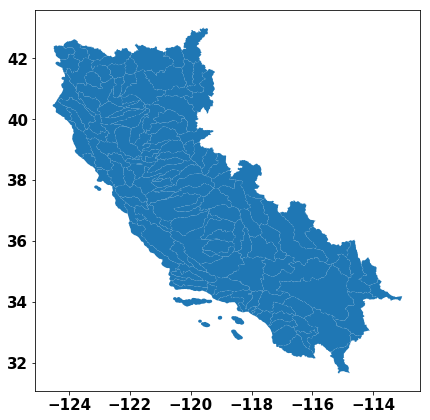

In [4]:
# let's also just plot the region
ca_regions.plot(figsize=(7,7))
PP.show()

# Aggregating the regions

The regions plotted above are the 8-digit Hydrologic Code units (see [https://en.wikipedia.org/wiki/Hydrological_code](https://en.wikipedia.org/wiki/Hydrological_code) for explanation).  These are relatively small features, whereas I want to do the analysis on larger regions, in order to have a large number of stations within each region.

Fortunately, USDA's Hydrologic Code system makes this simple: units are organized by a code (8-digits for the region above), where shorter codes correspond to larger aggregated regions.  Simply removing the last 2 digits of the 8-digit codes will aggregate the hydrologic units into reasonably large regions.

In [5]:
""" set the HUC6 codes (see https://en.wikipedia.org/wiki/Hydrological_code) """
# the HUC6 codes are simply the first 6 characters in the HUC8 codes
ca_regions['HUC6'] = ca_regions['HUC8'].apply(lambda x: x[:6])

## Assigning colors to HUC6 regions

In the rest of this notebook, it will help visually if there is a nice method for assigning distinct colors to each HUC6 region.  The following code assigns a random color to each HUC6 region.

In [6]:
""" Generate a color-mapping for HUC6 regions """
all_named_colors = mpl.colors.LinearSegmentedColormap.from_list("all_named_colors", list(mpl.colors.CSS4_COLORS))

# get a list of all unique HUC6 codes
unique_huc6_codes = list(set(ca_regions['HUC6']))

# randomly assign color indices to the unique HUC6 codes
random.seed(0) # seed the random number generator so this is repeatable
color_options = random.choice(len(list(mpl.colors.CSS4_COLORS)),size=len(unique_huc6_codes),replace=False)
# create a dictionary for assigning colors to HUC6 regions (we'll use this for stations later)
huc6_color_dict = dict(zip(unique_huc6_codes,color_options))

Now that we have colors for each HUC6 region, let's create a column in the GeoDataFrame that gives the corresponding color index; this will make it simple to generate color-coded maps.

In [7]:
# set the color indices for the CA regions
ca_regions['HUC6 Color Index'] = [ huc6_color_dict[c] for c in ca_regions['HUC6']]

Now that this is all prepared, the following cell demonstrates how simple it is to color-code the HUC8 regions by the corresponding HUC6 color:

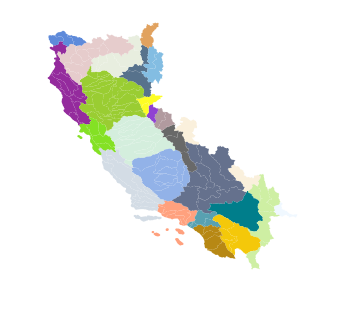

In [8]:
""" Plot the shapefile's regions, color-coded by HUC6 region """

# generate the plot
ax = ca_regions.plot(column='HUC6 Color Index',cmap=all_named_colors, figsize=(5,5))

# turn off the coordinate axes
ax.axis('off')

# draw the plot
PP.show()

## Creating a new HUC6 GeoDataFrame

For the rest of this notebook, I only want to work with HUC6 regions, so it would make sense to make a geopandas DataFrame (a GeoDataFrame) out of only the HUC6 shapes.  The following cell shows how to combine HUC8 shapes into larger HUC6 regions.

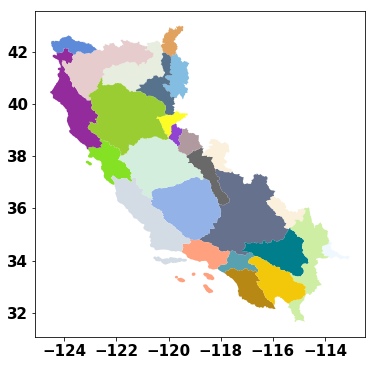

In [9]:
""" Create a new HUC6 geodataframe and plot it  """

df_dict = {'HUC6': [], 'HUC6 Color Index' : []}
geometries = []
# loop over the unique huc6 codes
for huc6_code in unique_huc6_codes:
    # find rows in the dataframe that have this HUC6 code
    huc6_inds = ca_regions['HUC6'] == huc6_code
    # append the code to the new dataframe
    df_dict['HUC6'].append(huc6_code)
    # also append the corresponding color to the dataframe
    df_dict['HUC6 Color Index'].append(huc6_color_dict[huc6_code])
    
    # use the `unary_union` feature to combine the matching HUC8 regions
    # into a single HUC6 region
    geometries.append(ca_regions['geometry'][huc6_inds].unary_union)
    
# create a GeoDataFrame from the HUC6 regions
ca_huc6_regions = geopandas.GeoDataFrame(df_dict,crs=ca_regions.crs, geometry = geometries)

# generate the plot
ca_huc6_regions.plot(column='HUC6 Color Index',cmap=all_named_colors, figsize = (6,6))

# draw the plot
PP.show()

# Reading the GHCND Station List

Now that we have the HUC6 regions, we need to get a list of all the GHCND station locations.

These are in the `ghcnd-station.txt` file.  According to the [GHCND Documentation](ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt), the `ghcnd-station.txt` file is a fixed-width format file with the following format:

```
IV. FORMAT OF "ghcnd-stations.txt"

------------------------------
Variable   Columns   Type
------------------------------
ID            1-11   Character
LATITUDE     13-20   Real
LONGITUDE    22-30   Real
ELEVATION    32-37   Real
STATE        39-40   Character
NAME         42-71   Character
GSN FLAG     73-75   Character
HCN/CRN FLAG 77-79   Character
WMO ID       81-85   Character
------------------------------
```

Fortunately, `pandas` can read fixed-width format files using the `pandas.read_fwf()` function.  Unfortunately, it needs to know which columns in the file correspond to which variables, and what types the variables are.  We could encode this iformation by hand, but why, when a computer can do it...

The following cell takes a multiline string into which I copied the above format table (note the use of triple-quotes `""" """` for a multiline string).  I then wrote a bit of code to parse this format table into the information needed for the `pandas.read_fwf()` routine (the following is directly from the `read_fwf()` documentation):

```
    names : array-like, default None
        List of column names to use. If file contains no header row, then you
        should explicitly pass header=None. Duplicates in this list will cause
        a ``UserWarning`` to be issued.
        
    colspecs : list of pairs (int, int) or 'infer'. optional
        A list of pairs (tuples) giving the extents of the fixed-width
        fields of each line as half-open intervals (i.e.,  [from, to[ ).
        String value 'infer' can be used to instruct the parser to try
        detecting the column specifications from the first 100 rows of
        the data which are not being skipped via skiprows (default='infer'). 
        
    dtype : Type name or dict of column -> type, default None
        Data type for data or columns. E.g. {'a': np.float64, 'b': np.int32}
        Use `str` or `object` to preserve and not interpret dtype.
        If converters are specified, they will be applied INSTEAD
        of dtype conversion.
```

Once the datatable is read in using pandas, I convert the lat/lon pairs, associated with each station, into `Point` objects (from the `shapely.geometry` library), which `geopandas` can then use to create a GeoDataFrame.

In [10]:
""" Read the GHCND Station List """
# this can be downloaded from ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt
ghcnd_station_index_file = "./ghcnd-stations.txt"

# The format of the ghcnd-stations.txt file
# (from ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt)
ghcnd_station_column_format = \
"""ID            1-11   Character
LATITUDE     13-20   Real
LONGITUDE    22-30   Real
ELEVATION    32-37   Real
STATE        39-40   Character
NAME         42-71   Character
GSN_FLAG     73-75   Character
HCN/CRN_FLAG 77-79   Character
WMO_ID       81-85   Character"""

# map the types above to Python types
type_mapping = {"Real" : float, "Character" : str }

# convert this into headers and fixed-width format specifiers expected by pandas.read_fwf()
names = []
colspecs = []
dtypes = []
for line in ghcnd_station_column_format.split('\n'):
    name, columns, ftype = line.split()
    # update the header
    # replace _ with blank space (I manually changed spaces in names to aid with parsing)
    names.append(name.replace('_',' '))
    
    # update the fixed-width specifier
    start,end = columns.split('-')
    colspecs.append((int(start)-1,int(end)-1))
    
    # update the data type
    dtypes.append(type_mapping[ftype])
    
# read the station index
stations = pd.read_fwf(ghcnd_station_index_file, names = names, colspecs=colspecs, dtypes=dtypes)

""" Convert the pandas dataframe into a geopandas dataframe """
# create shapely points for the lat/lon values for each station
geometry = [shapely.geometry.Point(xy) for xy in zip(stations['LONGITUDE'], stations['LATITUDE'])]

# remove the lat/lon columns
stations = stations.drop(['LONGITUDE', 'LATITUDE'], axis=1)

# create a geopandas dataframe out of the pandas dataframe
# set the CRS to the one used by the CA HUC shapefile
stations = geopandas.GeoDataFrame(stations, crs=ca_regions.crs, geometry=geometry)

stations

ID  ELEVATION STATE                      NAME GSN FLAG  \
0       ACW0001160       10.0   NaN     ST JOHNS COOLIDGE FLD      NaN   
1       ACW0001164       19.0   NaN                  ST JOHNS      NaN   
2       AE00004119       34.0   NaN       SHARJAH INTER. AIRP       GS   
3       AEM0004119       10.0   NaN                DUBAI INTL      NaN   
4       AEM0004121       26.0   NaN            ABU DHABI INTL      NaN   
5       AEM0004121      264.0   NaN               AL AIN INTL      NaN   
6       AF00004093     3366.0   NaN              NORTH-SALANG       GS   
7       AFM0004093      977.0   NaN                     HERAT      NaN   
8       AFM0004094     1791.0   NaN                KABUL INTL      NaN   
9       AFM0004099     1010.0   NaN          KANDAHAR AIRPORT      NaN   
10      AG00006039       24.0   NaN        ALGER-DAR EL BEIDA       GS   
11      AG00006059      397.0   NaN                  EL-GOLEA       GS   
12      AG00006061      561.0   NaN                 IN-AMENAS       GS   
13      AG00006068     1362.0   NaN               TAMANRASSET       GS   
14      AGE0013503       50.0   NaN    ORAN-HOPITAL MILITAIRE      NaN   
15      AGE0014770      161.0   NaN       ANNABA-CAP DE GARDE      NaN   
16      AGE0014770       59.0   NaN  ALGIERS-VILLE/UNIVERSITE      NaN   
17      AGE0014770      344.0   NaN         ALGIERS-BOUZAREAH      NaN   
18      AGE0014770       38.0   NaN        ALGIERS-CAP CAXINE      NaN   
19      AGE0014770      222.0   NaN                TIZI OUZOU      NaN   
20      AGE0014770      942.0   NaN             FORT NATIONAL      NaN   
21      AGE0014771        9.0   NaN      BEJAIA-BOUGIE (PORT)      NaN   
22      AGE0014771      660.0   NaN               CONSTANTINE      NaN   
23      AGE0014771      112.0   NaN      ORLEANSVILLE (CHLEF)      NaN   
24      AGE0014771     1081.0   NaN                     SETIF      NaN   
25      AGE0014771       78.0   NaN           ORAN-CAP FALCON      NaN   
26      AGE0014771      863.0   NaN                   TEBESSA      NaN   
27      AGE0014771       83.0   NaN       NEMOURS (GHAZAOUET)      NaN   
28      AGE0014771      476.0   NaN            SIDI-BEL-ABBES      NaN   
29      AGE0014771      125.0   NaN                    BISKRA      NaN   
...            ...        ...   ...                       ...      ...   
100828  ZA00006758     1032.0   NaN                   CHIPATA       GS   
100829  ZA00006758     1143.0   NaN                   LUNDAZI      NaN   
100830  ZA00006763     1053.0   NaN                     MONGU       GS   
100831  ZA00006764     1213.0   NaN                     KAOMA      NaN   
100832  ZA00006765      978.0   NaN              KAFUE POLDER      NaN   
100833  ZA00006766     1213.0   NaN              MOUNT MAKULU      NaN   
100834  ZA00006774      951.0   NaN                   SESHEKE      NaN   
100835  ZA00006774      986.0   NaN               LIVINGSTONE       GS   
100836  ZA00006775     1278.0   NaN                     CHOMA      NaN   
100837  ZAM0006766     1207.0   NaN            KABWE/MILLIKEN      NaN   
100838  ZI00006775      617.0   NaN                     BINGA      NaN   
100839  ZI00006776      518.0   NaN                    KARIBA      NaN   
100840  ZI00006776     1344.0   NaN                     KAROI      NaN   
100841  ZI00006777     1480.0   NaN          HARARE (KUTSAGA)       GS   
100842  ZI00006777      966.0   NaN              MOUNT DARWIN      NaN   
100843  ZI00006778     1244.0   NaN                    MUTOKO      NaN   
100844  ZI00006778     1480.0   NaN                    MVURWI      NaN   
100845  ZI00006784     1062.0   NaN            VICTORIA FALLS      NaN   
100846  ZI00006785     1077.0   NaN       HWANGE NATIONAL PAR      NaN   
100847  ZI00006786     1282.0   NaN                     GOKWE      NaN   
100848  ZI00006786     1215.0   NaN                    KWEKWE      NaN   
100849  ZI00006786     1429.0   NaN                     GWERU      NaN   
100850  ZI00006788  

# Finding stations within the HUC6 Regions

## First, find stations within the CA watershed region

Now that we have the GHCND station locations and the HUC6 regions, we can find out which stations are within each HUC6 watershed.  Since the GHCND dataset is a global dataset, the first step is to reduce the number of stations in the GeoDataFrame by removing stations that aren't within the CA watershed boundaries:

In [11]:
""" Find the stations within the CA region """
# get the union of all shapes w/in CA; this is the shape of CA's basin
ca_basin_shape = ca_regions.unary_union

# get a true/false mask indicating whether stations are in CA
ca_stations_inds = [ point.within(ca_basin_shape) for point in list(stations['geometry']) ]    

# extract only those in the CA region
ca_stations = stations[ca_stations_inds]

# simply type the name of the GeoDataFrame to make it print like a table
ca_stations

ID  ELEVATION STATE                           NAME GSN FLAG  \
39367  MX00000203        3.0   NaN                       MEXICALI      NaN   
39368  MX00000203      140.0   NaN                PRESA RODRIGUEZ      NaN   
39372  MX00000206       45.0   NaN                VALLE DE PALMAS      NaN   
39581  MXM0007604       11.0   NaN           EJIDO NUEVO LEON BC.      NaN   
48101  US1AZMH000     1061.0     A           GOLDEN VALLEY 10.1 N      NaN   
48103  US1AZMH000      861.0     A          GOLDEN VALLEY 2.6 WNW      NaN   
48104  US1AZMH000      169.0     A                 TOPOCK 3.3 NNW      NaN   
48105  US1AZMH000      295.0     A              LAKE HAVASU 2.6 N      NaN   
48106  US1AZMH000      451.0     A             LAKE HAVASU 3.5 NE      NaN   
48107  US1AZMH001      331.0     A           BULLHEAD CITY 3.8 NE      NaN   
48108  US1AZMH001      146.0     A           MOHAVE VALLEY 1.8 SW      NaN   
48111  US1AZMH002     1227.0     A               CHLORIDE 0.2 WNW      NaN   
48605  US1CAAL000      113.0     C                PIEDMONT 1.0 SE      NaN   
48606  US1CAAL000       87.0     C          CASTRO VALLEY 0.5 WSW      NaN   
48607  US1CAAL000      163.0     C          CASTRO VALLEY 0.4 NNE      NaN   
48608  US1CAAL000      107.0     C             PLEASANTON 1.8 SSE      NaN   
48609  US1CAAL000       58.0     C                OAKLAND 4.4 NNW      NaN   
48610  US1CAAL000        9.0     C                FREMONT 2.6 ESE      NaN   
48611  US1CAAL000      268.0     C               BERKELEY 3.8 ESE      NaN   
48612  US1CAAL001        9.0     C            SAN LORENZO 0.5 NNW      NaN   
48613  US1CAAL001      104.0     C             PLEASANTON 0.4 ESE      NaN   
48614  US1CAAL001       39.0     C                 OAKLAND 1.0 NE      NaN   
48615  US1CAAL001      120.0     C                 OAKLAND 7.8 SE      NaN   
48616  US1CAAL001      399.0     C                OAKLAND 5.0 NNE      NaN   
48617  US1CAAL001      349.0     C                 BERKELEY 4.0 E      NaN   
48618  US1CAAL002       27.0     C                BERKELEY 0.9 NE      NaN   
48619  US1CAAL002        9.0     C                 FREMONT 1.9 SE      NaN   
48620  US1CAAL002       16.0     C                   ALBANY 1.7 E      NaN   
48621  US1CAAL003       35.0     C                OAKLAND 1.2 ENE      NaN   
48622  US1CAAM000     1063.0     C                 VOLCANO 5.4 NE      NaN   
...           ...        ...   ...                            ...      ...   
99759  USW0009312        4.0     C             SANTA BARBARA MCAS      NaN   
99761  USW0009313       70.0     C    LOS ANGELES DWTN USC CAMPUS      NaN   
99762  USW0009313      128.0     C           PALM SPRINGS RGNL AP      NaN   
99766  USW0009314       73.0     A                   YUMA WB CITY      NaN   
99768  USW0009318       16.0     C        SANTA ANA JOHN WAYNE AP      NaN   
99769  USW0009319      101.0     C        FRESNO YOSEMITE INTL AP       GS   
99770  USW0009319       53.0     C           SANTA MONICA MUNI AP      NaN   
99772  USW0009320       18.0     C          MARYSVILLE YUBA CO AP      NaN   
99773  USW0009320       61.0     C             SAN LUIS OBISPO AP      NaN   
99774  USW0009320      246.0     C            PASO ROBLES MUNI AP      NaN   
99775  USW0009321       57.0     C               OROVILLE MUNI AP      NaN   
99776  USW0009321        2.0     C                    OAKLAND NAS      NaN   
99777  USW0009321      116.0     C                 VANDENBERG AFB      NaN   
99778  USW0009321      111.0     C                 VANDENBERG AFB      NaN   
99779  USW0009321       38.0     C                      BEALE AFB      NaN   
99780  USW0009321       43.0     C                         FT ORD      NaN   
99781  USW0009321      317.0     C        JOLON FT HUNTER LIGGETT      NaN   
99782  USW0009321       24.0     C  VANDENBERG AFB BOATHOUSE SITE      NaN   
99783  USW0009322      100.0     C      VANDENBERG AFB SUDDEN RCH      NaN   
99784  USW0009322        7.0     C   

## Second, assign stations to HUC6 regions

The `ca_stations` GeoDataFrame now contains only stations withn the CA watershed regions.  Now in order to assign the stations to HUC6 regions, we simply loop through all the stations, and then for each station loop through all the HUC6 regions until we find the region containing it:

In [12]:
""" Find which HUC6 region each station belongs to """
huc6_station_assignments = []
for point in list(ca_stations['geometry']):
    for huc6_code,huc6_geometry in zip(ca_huc6_regions['HUC6'],ca_huc6_regions['geometry']):
        # check if the point is within the current geometry
        if point.within(huc6_geometry):
            # if so, append its code to the list
            huc6_station_assignments.append(huc6_code)
            break

# update the geodataframe  with the HUC6 station index and color code
ca_stations['HUC6'] = huc6_station_assignments       

# also add colors
ca_stations['HUC6 Color Index'] = [huc6_color_dict[huc6_code] for huc6_code in huc6_station_assignments]

## Demonstrating that this worked

Now that we think we have each station assigned to its respective HUC6 region, we want to somehow show that this is true.  A simple way to do this is to plot the station locations, with each point colored by it's HUC6 region. Since `ca_stations` is a GeoDataFrame, and since the above cell assigned HUC6 region colors to each station, this is simple:

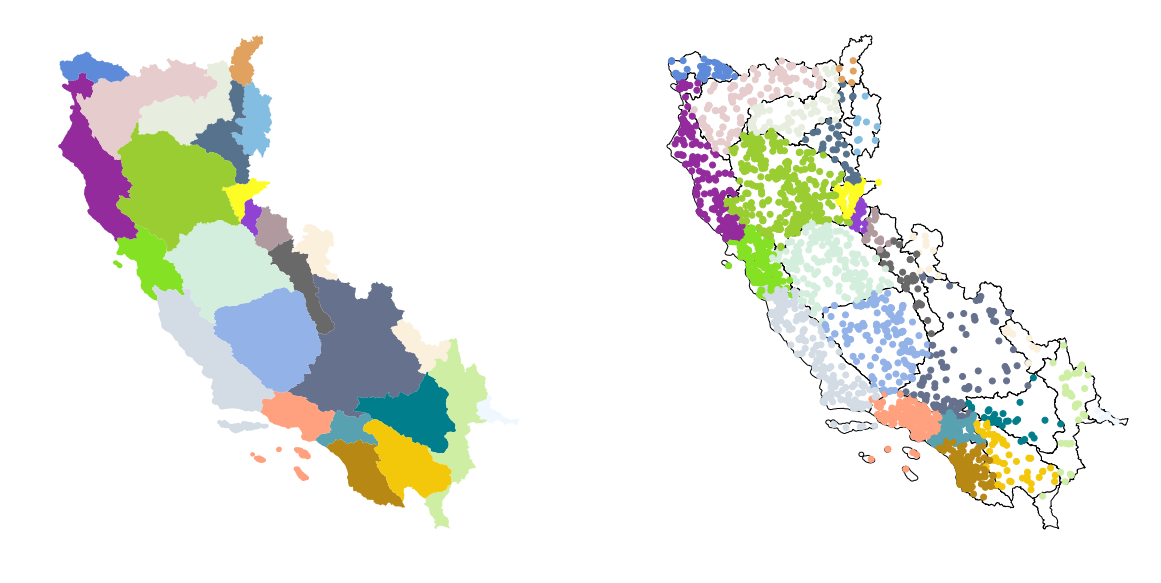

In [13]:
""" Plot the locations of the stations"""
fig,axs = PP.subplots(1,2,figsize=(20,10))

# plot the HUC6 regions in the left plot
ax = axs[0]
# generate the plot
ca_huc6_regions.plot(ax=ax,column='HUC6 Color Index',cmap=all_named_colors)

# turn of the coordinate axes
ax.axis('off')

# plot the GHCND Station Locations in the right plot
ax = axs[1]
# plot the outlines of the HUC6 regions
ca_huc6_regions.plot(ax=ax,color='white',edgecolor='black')

# plot the stations
ca_stations.plot(ax=ax,column = 'HUC6 Color Index', cmap = all_named_colors, marker='o')

# turn off axes
ax.axis('off')

# draw
PP.show()

## Plotting station elevations (just 'cuz we can)

To further demonstrate the utility of GeoDataFrames, we can generate plots based on any associated data.  For example, since we read in station elevations from the `ghcnd-stations.txt` file, we can easily generate a plot where points are color-coded by the station elevation:

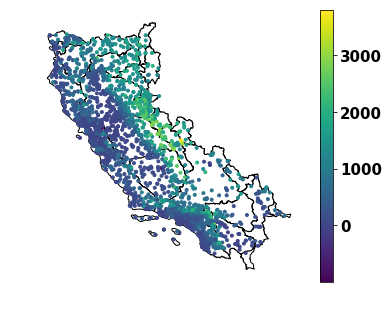

In [14]:
""" Plot station elevations """
fig, ax = PP.subplots(figsize=(6,5))

# plot the outlines of the HUC6 regions
ca_huc6_regions.plot(ax=ax,color='white',edgecolor='black')
# plot the stations, colored by elevation
elevation_plot = ca_stations.plot(ax=ax,column='ELEVATION',marker='.',legend=True)

ax.axis('off')

PP.show()

## Saving data

And finally, we can easily write the data to a file (e.g., to share with a colleague, which was the actual use-case for me creating this notebook originally) using `pandas` routines that come with `geopandas`:

In [15]:
""" Save the station list to a file for use later """
ca_stations.to_csv('ghcnd_stations_in_ca_basins.csv',index=False)